# Porod, Guinier and the Invariant
This scrit is supposed to do the following: \
Find 1D scattering curves in a directory \
Do the Porod fitting \
Subtract the q-Independent scattering and save the 1D curve \
\
Later Guinier fit can be done to calculate the invariant scattering via extrapolation

## Libraries

In [4]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

## Job Parameters

In [45]:
# give the metadada directory
data_dir = 'C:\\Users\\eikeg\\Documents\\Science\\Xe_Physisorption\\SAXS_4774'

# give the target file tyle:
target_file_type = '.dat'

porodFitting = True
guinierFitting = True
plotFitResults = True

# Fitting limits
# for high q regime - using porod like fitting
q_pe_min = 1.0 # Porod Fitting Range
q_pe_max = 3.5 # Porod fitting Range
q_pe_skipPoints = 30 # points to skip at the end indipendent from the actual q-range

# for high q regime - using Guinier like fitting
q_gu_min = 0.05 # Porod Fitting Range
q_gu_max = 0.3 # Porod fitting Range
q_gu_skipPoints = 1 # points to skip at the beginning indipendent from the actual q-range

# extrapolation to low and high q-values
q_extra_low = 0.01
q_extra_high = 20

# Porod Fit Funktions
c0_start = 0.03
c1_start = 0.000001
c4_start = 0.02
a_min = 4.0 # minimal expected exponent
a_max = 4.9 # maximal expected exponent
def porod_ext(x, c0, c1, c4, a):
    return c0 + c1 * x + c4 * x**(-a)

# Guinier Fit Funktions
i0_start = 200
rG_start = 4
def guinier(x, i0, rG):
    return i0 * np.exp(- rG**2 *x**(2/3))

## Job
### Search the directory

In [46]:
# scan the directory
fileList = list()
for entry in os.scandir(data_dir):
    if entry.path.endswith(target_file_type) and entry.is_file():
        fileList.append(entry.path)

fileIterator = iter(fileList)
dF=pd.DataFrame()
for element in fileIterator: 
    dF = dF.append({'FileName':element.split(os.sep)[-1]},ignore_index=True)

C:\Users\eikeg\Documents\Science\Xe_Physisorption\SAXS_4774\Step0_PorousSi_4774_608.dat
Porod Optimization range used is: 0.99617114  to  3.3948465  nm-1 between Index  68  and  251
Guinier Optimization range used is: 0.10486012  to  0.28836534  nm-1 between Index  68  and  251
C:\Users\eikeg\Documents\Science\Xe_Physisorption\SAXS_4774\Step10_PorousSi_4774_889.dat
Porod Optimization range used is: 0.99617114  to  3.3948465  nm-1 between Index  68  and  251
Guinier Optimization range used is: 0.10486012  to  0.28836534  nm-1 between Index  68  and  251
C:\Users\eikeg\Documents\Science\Xe_Physisorption\SAXS_4774\Step11_PorousSi_4774_917.dat
Porod Optimization range used is: 0.99617114  to  3.3948465  nm-1 between Index  68  and  251
Guinier Optimization range used is: 0.10486012  to  0.28836534  nm-1 between Index  68  and  251
C:\Users\eikeg\Documents\Science\Xe_Physisorption\SAXS_4774\Step12_PorousSi_4774_945.dat
Porod Optimization range used is: 0.99617114  to  3.3948465  nm-1 betwee

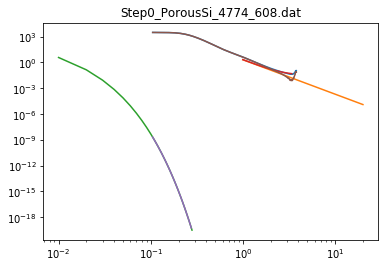

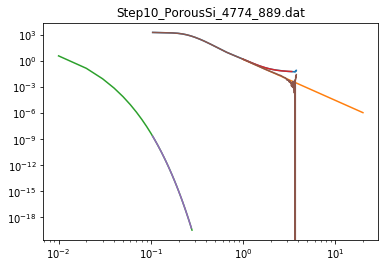

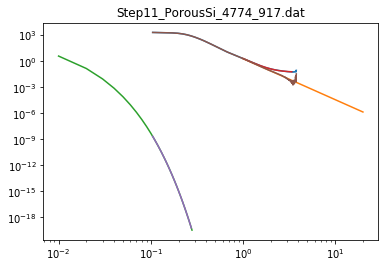

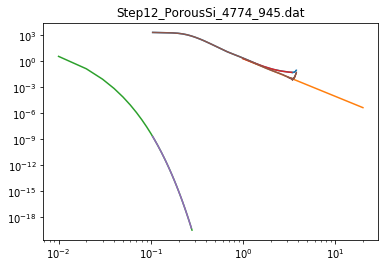

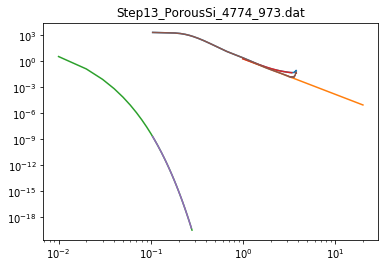

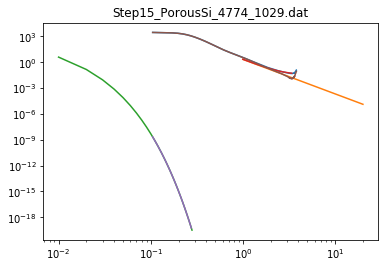

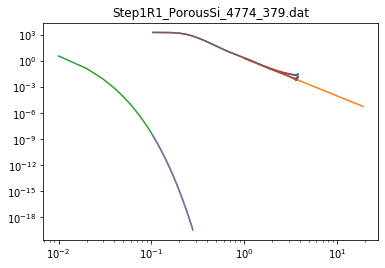

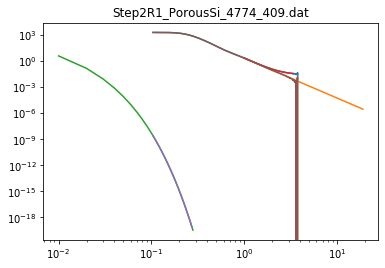

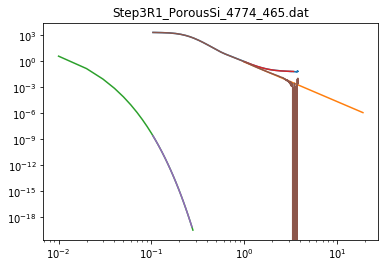

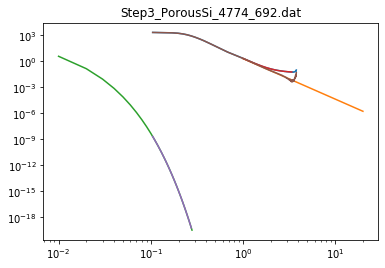

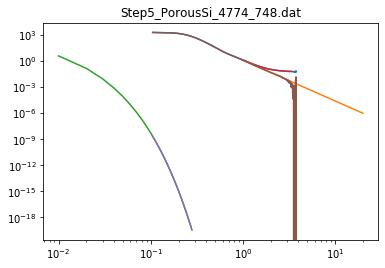

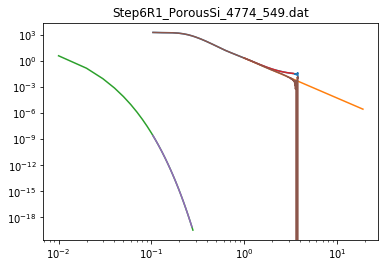

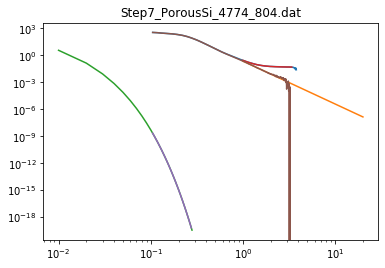

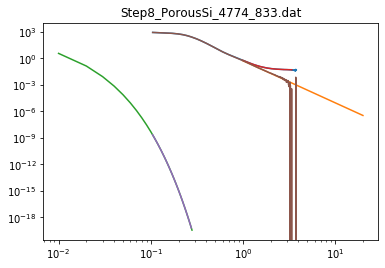

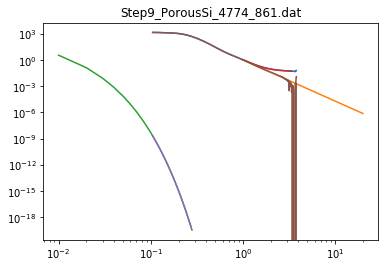

In [47]:
# make an path iterator from the found files
fileIterator = iter(fileList)
dF_pe=pd.DataFrame()
dF_gu=pd.DataFrame()

for element in fileIterator:
    q, I, e = np.genfromtxt(element,delimiter=',',unpack=True) # np.genfromtxt(element,skip_header=0,unpack=True)
    print(element)
    
    if porodFitting == True: 
        # Define Fitting range
        q_shop = q[:-q_pe_skipPoints]
        q_pe_IndexMin = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_min))
        q_pe_IndexMax = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_max))
        print('Porod Optimization range used is:',q[q_pe_IndexMin],' to ',q[q_pe_IndexMax],' nm-1 between Index ',q_pe_IndexMin,' and ',q_pe_IndexMax)
        # Actual Fitting
        param_bounds_pe=([0,0,0,a_min],[10*c0_start,10*c1_start,100*c4_start,a_max])
        popt, pcov =optimize.curve_fit(porod_ext,q[q_pe_IndexMin:q_pe_IndexMax],I[q_pe_IndexMin:q_pe_IndexMax],bounds=param_bounds_pe,sigma=e[q_pe_IndexMin:q_pe_IndexMax])
        # Output Data
        dF_pe = dF_pe.append({'Porod_qMin':q[q_pe_IndexMin],'Porod_qMax':q[q_pe_IndexMax],'c0':popt[0],'c1':popt[1],'c4':popt[2],'a':popt[3]},ignore_index=True)
        #dF = dF.append(dF_pe)
        # Plotting the result
        if plotFitResults == True and guinierFitting == False:
            q_pe = q[q_pe_IndexMin:q_pe_IndexMax]
            I_pe = porod_ext(q_pe,popt[0], popt[1], popt[2], popt[3])
            fig, ax = plt.subplots()
            ax.plot(q, I)
            ax.plot(q_pe, I_pe)
            ax.plot(q,I-popt[0])
            plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
            ax.loglog()
        else:
            pass
        I_out=I-popt[0]
        
    if guinierFitting == True:
        # Define Fitting range
        q_gu_shop = q[q_gu_skipPoints:]
        q_gu_IndexMin = min(range(q_gu_shop.size), key=lambda i: abs(q_gu_shop[i]-q_gu_min))
        q_gu_IndexMax = min(range(q_gu_shop.size), key=lambda i: abs(q_gu_shop[i]-q_gu_max))
        print('Guinier Optimization range used is:',q[q_gu_IndexMin],' to ',q[q_gu_IndexMax],' nm-1 between Index ',q_pe_IndexMin,' and ',q_pe_IndexMax)
        # Actual Fitting
        param_bounds_gu=([0.1*i0_start,0.5*rG_start],[10*i0_start,5*rG_start])
        popt_gu, pcov_gu =optimize.curve_fit(guinier,q[q_gu_IndexMin:q_gu_IndexMax],I[q_gu_IndexMin:q_gu_IndexMax],bounds=param_bounds_gu,sigma=e[q_gu_IndexMin:q_gu_IndexMax])
        # Output Data
        dF_gu = dF_gu.append({'Guinier_qMin':q[q_gu_IndexMin],'Guinier_qMax':q[q_gu_IndexMax],'i0':popt_gu[0],'rG':popt_gu[1],},ignore_index=True)
        # Plotting the result
        if plotFitResults == True and porodFitting == False:
            q_gu = q[q_gu_IndexMin:q_gu_IndexMax]
            I_gu = guinier(q_gu,popt_gu[0], popt_gu[1])
            fig, ax = plt.subplots()
            ax.plot(q, I)
            ax.plot(q_gu, I_gu)
            #ax.plot(q,I-popt[0])
            plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
            ax.loglog()
        else:
            pass
    if plotFitResults == True and porodFitting == True and guinierFitting == True:
        q_pe = q[q_pe_IndexMin:q_pe_IndexMax]
        I_pe = porod_ext(q_pe,popt[0], popt[1], popt[2], popt[3])
        q_gu = q[q_gu_IndexMin:q_gu_IndexMax]
        I_gu = guinier(q_gu,popt_gu[0], popt_gu[1])
        q_pe_extra = np.arange(q[q_pe_IndexMin], q_extra_high, 1)
        q_gu_extra = np.arange(q_extra_low, q[q_gu_IndexMax], 0.01)
        
        fig, ax = plt.subplots()
        ax.plot(q, I)
        ax.plot(q_pe_extra, porod_ext(q_pe_extra,0, 0, popt[2], popt[3]))
        ax.plot(q_gu_extra, guinier(q_gu_extra,popt_gu[0], popt_gu[1]))
        ax.plot(q_pe, I_pe)
        ax.plot(q_gu, I_gu)
        
        #I_subtraced = porod_ext(q,popt[0], popt[1], 0, 0)
        ax.plot(q,I-porod_ext(q,popt[0], popt[1], 0, 0))
        plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
        ax.loglog()
    else:
        pass
    
    # Save Numpy array to csv with header    
#    save_file_name = element[:-4]+'_c0_Sub'+'.dat'
#    file_header = str(element.split(os.sep)[-1])+'\tc0_Subtracted c0=\t'+str(popt[0])+'\n'+'q\tI\tPoisson error\nnm-1\tcm-1\tcm-1'
#    np.savetxt(save_file_name, np.column_stack((q, I_out, e)), delimiter='\t', header=file_header)

# Save Pandas Frame to csv with header    
outputFrame = pd.concat([dF,dF_pe,dF_gu],axis=1)
#save_outPut_name = data_dir+os.sep+'Porod_logg'+'.txt'
#outputFrame.to_csv(save_outPut_name, sep='\t')

In [48]:
outputFrame

,FileName,Porod_qMax,Porod_qMin,a,c0,c1,c4,Guinier_qMax,Guinier_qMin,i0,rG
0,Step0_PorousSi_4774_608.dat,3.394846,0.996171,4.000000,0.033348,4.317482e-14,2.000000,0.288365,0.10486,1010.0,11.0
1,Step10_PorousSi_4774_889.dat,3.394846,0.996171,4.718525,0.053535,7.576579e-20,1.478822,0.288365,0.10486,1010.0,11.0
2,Step11_PorousSi_4774_917.dat,3.394846,0.996171,4.727246,0.050860,4.722743e-20,1.865100,0.288365,0.10486,1010.0,11.0
3,Step12_PorousSi_4774_945.dat,3.394846,0.996171,4.345528,0.042496,1.678683e-19,2.000000,0.288365,0.10486,1010.0,11.0
4,Step13_PorousSi_4774_973.dat,3.394846,0.996171,4.097157,0.035966,1.000000e-05,2.000000,0.288365,0.10486,1010.0,11.0
5,Step15_PorousSi_4774_1029.dat,3.394846,0.996171,4.000000,0.034479,3.186998e-21,2.000000,0.288365,0.10486,1010.0,11.0
6,Step1R1_PorousSi_4774_379.dat,3.406000,1.001000,4.328448,0.014908,1.000000e-05,2.000000,0.286000,0.10400,1010.0,11.0
7,Step2R1_PorousSi_4774_409.dat,3.406000,1.001000,4.586447,0.026913,4.872124e-24,2.000000,0.286000,0.10400,1010.0,11.0
8,Step3R1_PorousSi_4774_465.dat,3.406000,1.001000,4.570714,0.060567,7.339355e-16,0.797660,0.286000,0.10400,1010.0,11.0
9,Step3_PorousSi_4774_692.dat,3.394846,0.996171,4.674126,0.050210,3.666111e-21,2.000000,0.288365,0.10486,1010.0,11.0


In [15]:
dF

,FileName
0,Step0_PorousSi_4774_608.dat
1,Step10_PorousSi_4774_889.dat
2,Step11_PorousSi_4774_917.dat
3,Step12_PorousSi_4774_945.dat
4,Step13_PorousSi_4774_973.dat
5,Step14_PorousSi_4774_1001.dat
6,Step15_PorousSi_4774_1029.dat
7,Step1R1_PorousSi_4774_379.dat
8,Step2R1_PorousSi_4774_409.dat
9,Step3R1_PorousSi_4774_465.dat
